In [1]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import FeatureUnion
import re
import xgboost as xgb
from sklearn.metrics import precision_score
import os
import gzip
import random
from matplotlib import pyplot as plt
from sklearn.pipeline import make_pipeline
import pickle
import seaborn as sns
from sklearn.metrics import confusion_matrix

/anaconda3/lib/python3.7/site-packages/dask/dataframe/utils.py:13: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
#Returns a string of length bytes long

def dataloader(filepath, length):
    f = gzip.GzipFile(fileobj=open(filepath, 'rb'))
    data = f.read(length)
    return data.decode("utf-8")

In [3]:
#Returns dataframe of # of files long. Analyze the first length bytes of each file

def trainloader(direclist, filetype, length):
    fileid = np.arange(len(filetype))
    dat = []
    filelabels = []
    c = -1
    for direc in direclist:
        c+=1
        for file in os.listdir(direc):
            if file.endswith('.gz'):
                tempdat = dataloader(os.path.join(direc,file),length)
                dat = dat + [tempdat]
                filelabels.append(fileid[c])
            if file.endswith('fastq.truncated'):
                tfile = open(os.path.join(direc,file), 'rb')
                tempdat = tfile.read(length).decode("utf-8")
                dat = dat + [tempdat]
                filelabels.append(fileid[c])
            if file.endswith('sra.truncated'):
                tfile = open(os.path.join(direc,file), 'rb')
                tempdat = tfile.read(length).decode("ISO-8859-1")
                dat = dat + [tempdat]
                filelabels.append(fileid[c])
    data = {'Data': dat,
        'Type': filelabels
    }
    df = pd.DataFrame(data, columns = ['Data', 'Type'])
    return(df)

In [4]:
# Returns rows of correctly classified features

def rowextraction(predicted, truth):
    return(np.where(predicted==truth)[0])

In [5]:
# Returns distribution of probability of class being correct for correctly classified features

def uncertainty(pred, row_ind, num_classes):
    class_arr = [[] for i in range(num_classes)]
    dist_arr = []
    for ind in row_ind:
        class_ind = np.argmax(pred[ind])
        class_arr[class_ind].append(np.max(pred[ind]))
    for arr in class_arr:
        dist_arr.append([np.mean(arr),np.std(arr)])
    return(dist_arr)

In [6]:
# Returns Graphs of Feature Importance by Importance Type

def FeatureImportance(model, features, importance):
    for im in importance:
        feature_important = model.get_score(importance_type = im)
        keys = list(feature_important.keys())
        feature_chars = []
        keylist = []
        for key in keys:
            keylist.append(int(key.replace('f','')))
        for i in keylist:
            feature_chars.append(features[i])
        values = list(feature_important.values())
        fdata = pd.DataFrame(data=values, index=feature_chars, columns=["score"]).sort_values(by = "score", ascending=False)
        fdata.plot(kind='barh', title = im)    
        
    

In [46]:
# Prints Confusion Matrix

def confusionmatrix(truth, pred, names):
    cm = confusion_matrix(truth, pred)
    plt.figure()
    plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    plt.colorbar().set_label("# Classified")
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.xlabel("Predicted Class")
    plt.ylabel("True Class")
    plt.title("Confusion Matrix")
    plt.show()

In [8]:
# Returns Accuracy Per Class

def classaccuracy(truth, pred, ind, num_classes):
    classes = np.arange(num_classes)
    predcl = np.asarray([np.argmax(pred[i]) for i in ind])
    acc = []
    for cl in classes:
        truth_len = len(np.where(truth == cl)[0])
        pred_len = len(np.where(predcl == cl)[0])
        acc.append(pred_len/truth_len)
    return(acc)

In [9]:
# No longer useful
def trainselector(train_data, train_label, n_class, split):
    labelmat = [[] for i in range(n_class)]
    splitnum = []
    datmat = []
    
    total_len = len(train_data)
    for s in split:
        nchoice = int(total_len*s)
        splitnum.append(nchoice)
    
    for c in range(n_class):
        t_labelloc = np.where(train_label == c)[0]
        labelmat[c].extend(train_data[t_labelloc])
   
    for n in range(len(splitnum)):
        datmat.extend(np.random.choice(labelmat[n],splitnum[n]))
    
    
    return(datmat)
        

In [11]:
#Splits our data into train/test

def Data_Splitter(Dataset, ttsplit):
    X = Dataset.iloc[:,0]
    y = Dataset.iloc[:,1]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=ttsplit, random_state = 42)

    return X_train, X_test, y_train, y_test

In [12]:
# No Longer Useful
def Char_vectorizer(X_train, y_train, X_test, y_test, filetype, fit_split, ngram_range, max_features, load):
    fitset = trainselector(np.array(X_train), np.array(y_train), len(filetype), fit_split)
    
    if load == False:
        print("Generating Character Vectorizer...")
        TfidfVectorizer.partial_fit = partial_fit
        char_vectorizer = TfidfVectorizer(analyzer = 'char',
            ngram_range = ngram_range, max_features = max_features)
        char_vectorizer.fit(fitset)
        print(char_vectorizer.vocabulary_)
        print(char_vectorizer.get_feature_names())
        char_vectorizer2 = TfidfVectorizer(analyzer = 'char',
            ngram_range = ngram_range, max_features = max_features,
                                vocabulary = char_vectorizer.vocabulary_)
        char_vectorizer2.fit(X_train)
        print(char_vectorizer2.vocabulary_)
        print(char_vectorizer2.get_feature_names())
        train_chars = char_vectorizer2.transform(X_train)
        test_chars = char_vectorizer2.transform(X_test)
        pickle.dump(char_vectorizer, open("tfidfcv.pkl", "wb"))
        print("Character Vectorizer Saved")
        
    if load == True:
        print("Loading Character Vectorizer...")
        char_vectorizer = pickle.load(open("tfidfcv.pkl", 'rb'))
        print("Character Vectorizer Loaded")
        print(char_vectorizer.vocabulary_)
        print(type(char_vectorizer.vocabulary_))
        print(char_vectorizer.get_feature_names())
        train_chars = char_vectorizer.transform(X_train)
        test_chars = char_vectorizer.transform(X_test)

    dtrain = xgb.DMatrix(train_chars, label = y_train)
    dtest = xgb.DMatrix(test_chars, label = y_test)
    
    return dtrain, dtest

In [13]:
# Trains XGB Classifier

def TrainFileClassifier(param, num_round, test_dat, load, output):
    if load == False:
        print("Training Model...")
        model = xgb.train(param, test_dat, num_round)
        pickle.dump(model, open("xgb_class.pkl", "wb"))
        print("Model Saved")
    if load == True:
        print("Loading Model...")
        model = pickle.load(open("xgb_class.pkl", "rb"))
        print("Model Loaded")

    return model
    

In [28]:
# Tests XGB Classifier

def TestFileClassifier(model, data_test, filetype, y_test, output):
    preds = model.predict(data_test)
    best_preds = np.asarray([np.argmax(line) for line in preds])
    if output == True:
        char_vectorizer = pickle.load(open("tfidfcv2.pkl", 'rb'))
        FeatureImportance(model, char_vectorizer.get_feature_names(), ['weight','cover','gain'])
        print("Precision: {}".format(precision_score(y_test, best_preds, average='macro')))
        y_test_arr = np.asarray(y_test).reshape(1,-1).squeeze()
        correct_rows = rowextraction(best_preds,y_test_arr)
        class_acc = classaccuracy(y_test_arr, preds, correct_rows, param['num_class'])
        pred_uncertainty = uncertainty(preds, correct_rows, param['num_class'])
        for i in range(param['num_class']):
            print("Class {}".format(filetype[i]) + " mean and sd: {}".format(pred_uncertainty[i])
                 + ", Accuracy: {}".format(round(class_acc[i],2)))
        confusionmatrix(y_test_arr, best_preds, filetype)
    print(len(best_preds))
    return best_preds

In [26]:
# Tf-idf Transformation on Training and Testing data based on max_features # of vocabulary words
# generated from each file class.

def Char_vectorizer2(X_train, y_train, X_test, y_test, filetype, ngram_range, max_features, load):
    
    fitset = trainselector2(np.array(X_train), np.array(y_train), len(filetype))
    
    if load == False:
        print("Generating Character Vectorizer...")
        char_vocab = {}
        for fileset in fitset:
            char_vectorizer = TfidfVectorizer(analyzer = 'char',
                ngram_range = ngram_range, max_features = max_features)
            char_vectorizer.fit(fileset)
            char_vocab.update(char_vectorizer.vocabulary_)
            
        count = -1
        for key in char_vocab.keys():
            count+=1
            char_vocab[key] = count
            
    
        char_vectorizer2 = TfidfVectorizer(analyzer = 'char',
                ngram_range = ngram_range, max_features = max_features,
                                vocabulary = char_vocab)
        char_vectorizer2.fit(X_train)
        print(char_vectorizer2.get_feature_names())
        
        train_chars = char_vectorizer2.transform(X_train)
        test_chars = char_vectorizer2.transform(X_test)
        pickle.dump(char_vectorizer2, open("tfidfcv2.pkl", "wb"))
        print("Character Vectorizer Saved")
        
    if load == True:
        print("Loading Character Vectorizer...")
        char_vectorizer = pickle.load(open("tfidfcv2.pkl", 'rb'))
        print("Character Vectorizer Loaded")
    
        print(char_vectorizer.get_feature_names())
        train_chars = char_vectorizer.transform(X_train)
        test_chars = char_vectorizer.transform(X_test)

    dtrain = xgb.DMatrix(train_chars, label = y_train)
    dtest = xgb.DMatrix(test_chars, label = y_test)
    
    
    
    return dtrain, dtest

In [16]:
# Splits our training data into parts by filetype

def trainselector2(train_data, train_label, n_class):
    labelmat = [[] for i in range(n_class)]
    
    for c in range(n_class):
        t_labelloc = np.where(train_label == c)[0]
        labelmat[c].extend(train_data[t_labelloc])
    
    return(labelmat)
        

In [17]:
dirs = ['/Users/bf/Desktop/BNL2020/BioClassifierFiles/genomic.fna',
        '/Users/bf/Desktop/BNL2020/BioClassifierFiles/genomic.gbff',
        '/Users/bf/Desktop/BNL2020/BioClassifierFiles/genomic.gff',
        '/Users/bf/Desktop/BNL2020/BioClassifierFiles/FASTQ_truncated',
        '/Users/bf/Desktop/BNL2020/BioClassifierFiles/SRA_truncated'
       ]
filetype = ['fna', 'gbff', 'gff', 'fastq', 'sra']
data_iterable = trainloader(dirs, filetype, 3000)

In [18]:
param = {
    'max_depth': 10,  # the maximum depth of each tree
    'eta': 0.1,  # the training step for each iteration
    'silent': 1,  # logging mode - quiet
    'objective': 'multi:softprob',  # error evaluation for multiclass training
    'num_class': len(filetype),  # the number of classes that exist in this datset
    'booster' : 'dart', # Dropout added
    'rate_drop' : 0.4, #Dropout Rate
    'skip_drop' : 0.4 # Probability of skipping Dropout
    } 
num_round = 40 # Number of rounds we train our XGB Classifier
ngram_range = (4,8) # Character length we search by for Tfidf
max_features = 10 # Vocab Words Per File Class
Dataset = data_iterable
ttsplit = 0.33 # Train/Test Split Percentage

In [19]:
X_train, X_test, y_train, y_test = Data_Splitter(Dataset, ttsplit)

In [20]:
dat2_train, dat2_test = Char_vectorizer2(X_train, y_train, X_test, y_test, filetype, ngram_range, max_features, load = False)

Generating Character Vectorizer...
['ttta', 'aaaa', 'aatt', 'taaa', 'tttt', 'aaat', 'attt', 'aaga', 'agaa', 'gaaa', 'tion', 'ion ', ' gen', 'geno', 'enom', 'atio', ' :: ', 'tion ', 'genom', 'ation', 'gene', 'prot', 'rote', 'otei', 'tein', 'prote', 'rotei', 'otein', 'rotein', 'protein', 'gggg', 'ggggg', 'gggggg', 'ggggggg', 'gggggggg', '????', '?????', '??????', '???????', '????????', '\x00\x00\x00\x00', '\x00\x00\x00$', '\x00\x00$\x01', '$\x01\x00\x00', '\x00\x00\x00\x00\x00', '\x00\x00\x00\x00$', '\x00\x00\x00\x00\x00\x00', '\x00\x00\x00$\x01\x00', '\x00\x00\x00\x00\x00\x00\x00', '\x00\x00\x00\x00\x00\x00\x00\x00']
Character Vectorizer Saved


In [22]:
model2 = TrainFileClassifier(param, num_round, dat2_train, load = False, output = False)

Training Model...
[01:57:40] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Model Saved


Feature Importance Graphs: 
Precision: 0.9804093567251462
Class fna mean and sd: [0.8811261, 0.05176799], Accuracy: 0.9
Class gbff mean and sd: [0.87371814, 0.06346902], Accuracy: 1.0
Class gff mean and sd: [0.87257856, 0.075715736], Accuracy: 1.0
Class fastq mean and sd: [0.8924623, 0.019304903], Accuracy: 0.98
Class sra mean and sd: [0.8964593, 0.0008378018], Accuracy: 1.0
Confusion Matrix: 


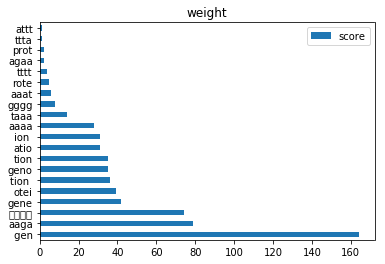

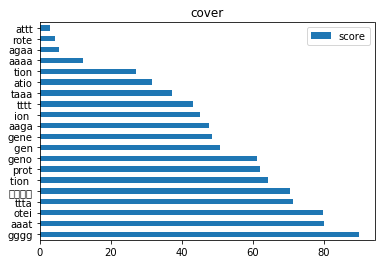

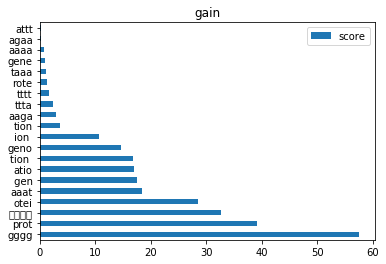

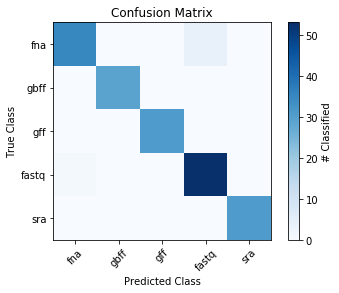

184


array([4, 1, 0, 2, 0, 3, 3, 0, 4, 4, 4, 0, 3, 3, 3, 1, 1, 0, 0, 4, 3, 1,
       0, 3, 4, 1, 4, 3, 0, 3, 1, 3, 2, 0, 4, 3, 0, 2, 4, 3, 4, 2, 4, 1,
       0, 2, 4, 3, 1, 2, 3, 1, 1, 3, 3, 2, 1, 3, 1, 3, 3, 2, 3, 0, 2, 4,
       3, 1, 0, 1, 4, 0, 0, 1, 2, 1, 1, 2, 0, 0, 3, 2, 4, 3, 3, 4, 2, 2,
       3, 1, 0, 2, 2, 2, 0, 2, 0, 2, 3, 1, 0, 2, 3, 0, 4, 1, 0, 0, 3, 0,
       3, 2, 2, 0, 3, 3, 2, 3, 3, 1, 0, 2, 4, 4, 1, 0, 3, 0, 3, 1, 0, 3,
       2, 4, 3, 4, 3, 3, 2, 3, 4, 3, 2, 3, 0, 2, 1, 1, 1, 1, 1, 3, 3, 4,
       4, 0, 4, 4, 4, 3, 1, 3, 3, 4, 0, 4, 0, 3, 3, 3, 2, 2, 4, 3, 0, 3,
       3, 3, 0, 3, 4, 2, 3, 3])

In [47]:
TestFileClassifier(model2, dat2_test, filetype, y_test, output = True)